In [15]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.cm import hsv
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torchvision.datasets import CIFAR10

In [16]:
def get_dataset_and_classes(dataset):
    if dataset == "cifar10":
        data_filepath = "wide_resnet_28_10_CIFAR10_0.937.pth"
        classes = CIFAR10(root="D:\\Dokumente\\Git\\dal-toolbox\\experiments\\self_supervised_learning\\data").classes
    elif dataset == "cifar100":
        data_filepath = "wide_resnet_28_10_CIFAR100_0.682.pth"
        classes = None
    elif dataset == "svhn":
        data_filepath = "wide_resnet_28_10_SVHN_0.905.pth"
        classes = [str(i) for i in range(10)]
    elif dataset == "imagenet100":
        data_filepath = "vits14_reg_ImageNet100_norm.pth"
        classes = None
    else:
        raise NotImplementedError()

    data = torch.load(data_filepath)
    train_features = data['trainset'].features
    train_labels = data['trainset'].labels
    test_features = data['testset'].features
    test_labels = data['testset'].labels
    return train_features, train_labels, test_features, test_labels, classes


def generate_pca(train_features, test_features):
    pca = PCA(n_components=2).fit(train_features)
    train_pca = pca.transform(train_features)
    test_pca = pca.transform(test_features)
    return train_pca, test_pca


def generate_tsne(train_features, test_features, perplexity=50):
    tsne = TSNE(n_components=2, random_state=0, n_jobs=4, perplexity=perplexity)
    features = torch.cat([train_features, test_features])
    tsne_features = tsne.fit_transform(features)

    train_tsne = tsne_features[:len(train_features)]
    test_tsne = tsne_features[len(train_features):]
    return train_tsne, test_tsne


def plot_feature_reps(train_reps, train_labels, test_reps, test_labels, classes=None, title=None):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    ax1, ax2 = axes[0], axes[1]
    cmap = 'tab10' if classes is not None else "tab20"

    ax1.scatter(train_reps[:, 0], train_reps[:, 1], c=train_labels, s=0.2, cmap=cmap)
    ax1.set_title("Trainset")
    sc = ax2.scatter(test_reps[:, 0], test_reps[:, 1], c=test_labels, s=0.2, cmap=cmap)
    ax2.set_title("Testset")
    if classes is not None:
        ax2.legend(handles=sc.legend_elements()[0], labels=classes)
    fig.suptitle(title)
    plt.show()

def generate_colormap(number_of_distinct_colors: int = 80):
    if number_of_distinct_colors == 0:
        number_of_distinct_colors = 80

    number_of_shades = 7
    number_of_distinct_colors_with_multiply_of_shades = int(math.ceil(number_of_distinct_colors / number_of_shades) * number_of_shades)

    # Create an array with uniformly drawn floats taken from <0, 1) partition
    linearly_distributed_nums = np.arange(number_of_distinct_colors_with_multiply_of_shades) / number_of_distinct_colors_with_multiply_of_shades

    # We are going to reorganise monotonically growing numbers in such way that there will be single array with saw-like pattern
    #     but each saw tooth is slightly higher than the one before
    # First divide linearly_distributed_nums into number_of_shades sub-arrays containing linearly distributed numbers
    arr_by_shade_rows = linearly_distributed_nums.reshape(number_of_shades, number_of_distinct_colors_with_multiply_of_shades // number_of_shades)

    # Transpose the above matrix (columns become rows) - as a result each row contains saw tooth with values slightly higher than row above
    arr_by_shade_columns = arr_by_shade_rows.T

    # Keep number of saw teeth for later
    number_of_partitions = arr_by_shade_columns.shape[0]

    # Flatten the above matrix - join each row into single array
    nums_distributed_like_rising_saw = arr_by_shade_columns.reshape(-1)

    # HSV colour map is cyclic (https://matplotlib.org/tutorials/colors/colormaps.html#cyclic), we'll use this property
    initial_cm = hsv(nums_distributed_like_rising_saw)

    lower_partitions_half = number_of_partitions // 2
    upper_partitions_half = number_of_partitions - lower_partitions_half

    # Modify lower half in such way that colours towards beginning of partition are darker
    # First colours are affected more, colours closer to the middle are affected less
    lower_half = lower_partitions_half * number_of_shades
    for i in range(3):
        initial_cm[0:lower_half, i] *= np.arange(0.2, 1, 0.8/lower_half)

    # Modify second half in such way that colours towards end of partition are less intense and brighter
    # Colours closer to the middle are affected less, colours closer to the end are affected more
    for i in range(3):
        for j in range(upper_partitions_half):
            modifier = np.ones(number_of_shades) - initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i]
            modifier = j * modifier / upper_partitions_half
            initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i] += modifier

    return ListedColormap(initial_cm)

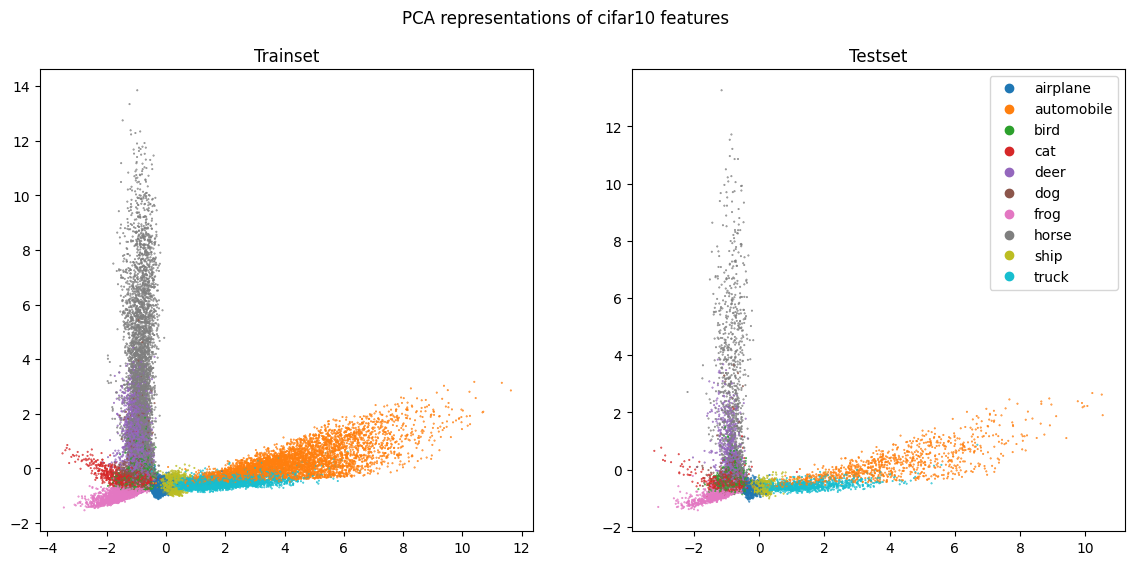

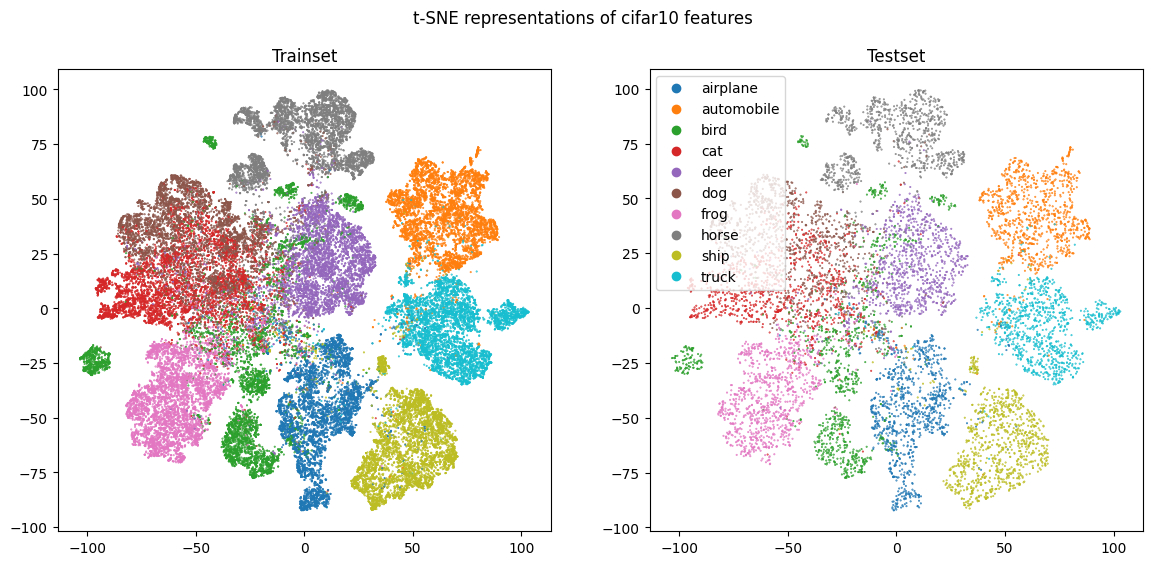

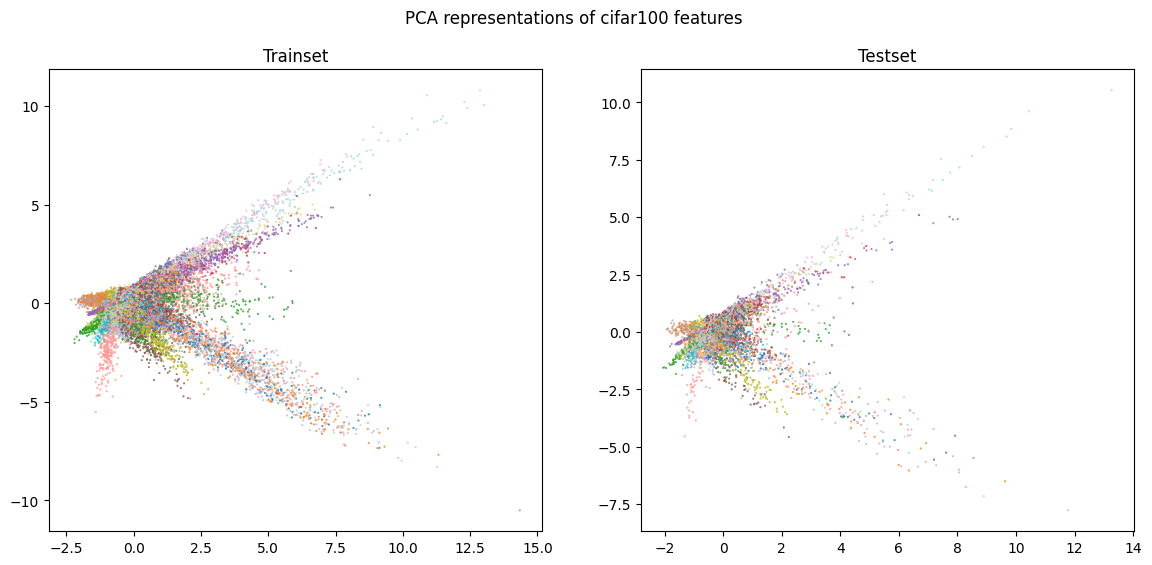

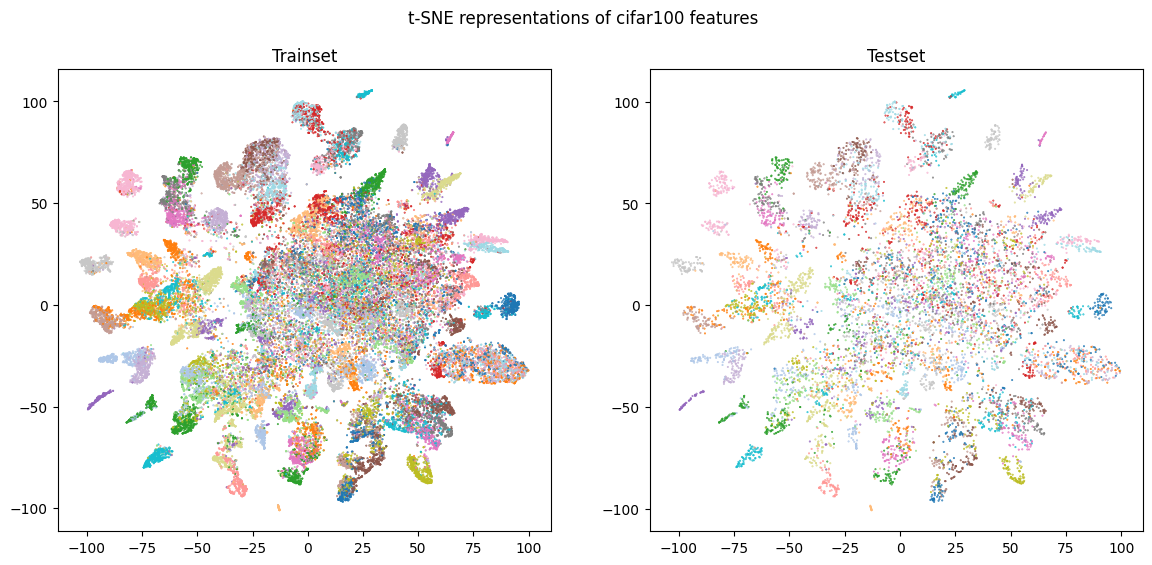

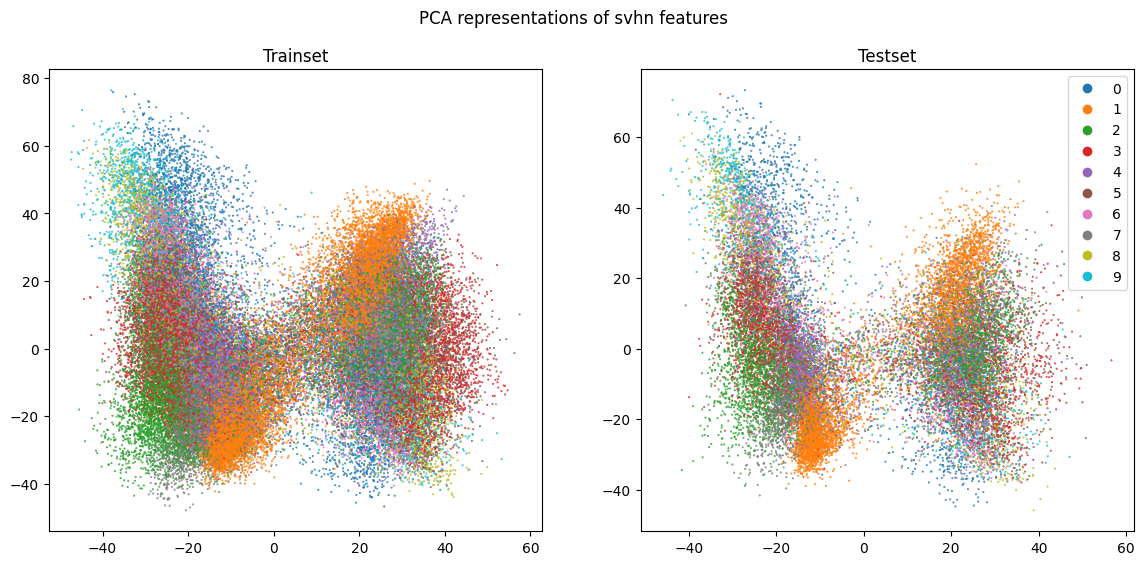

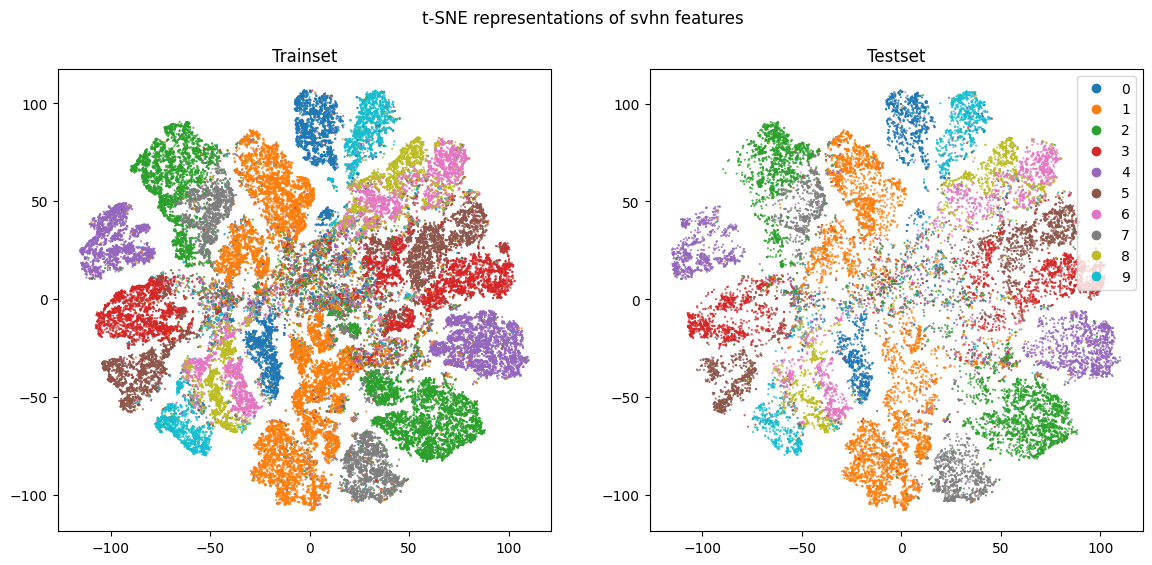

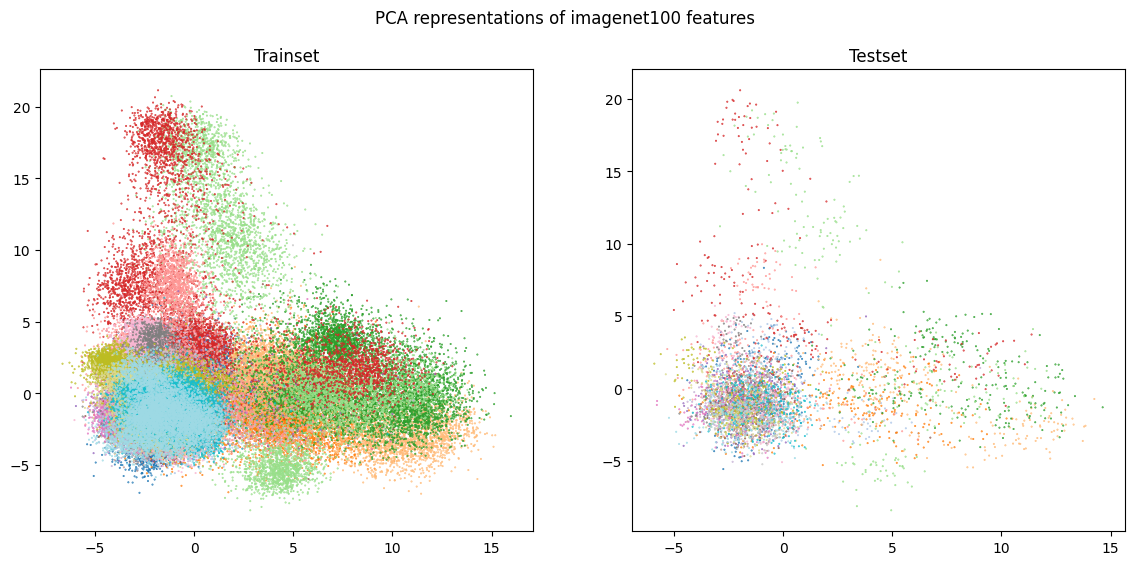

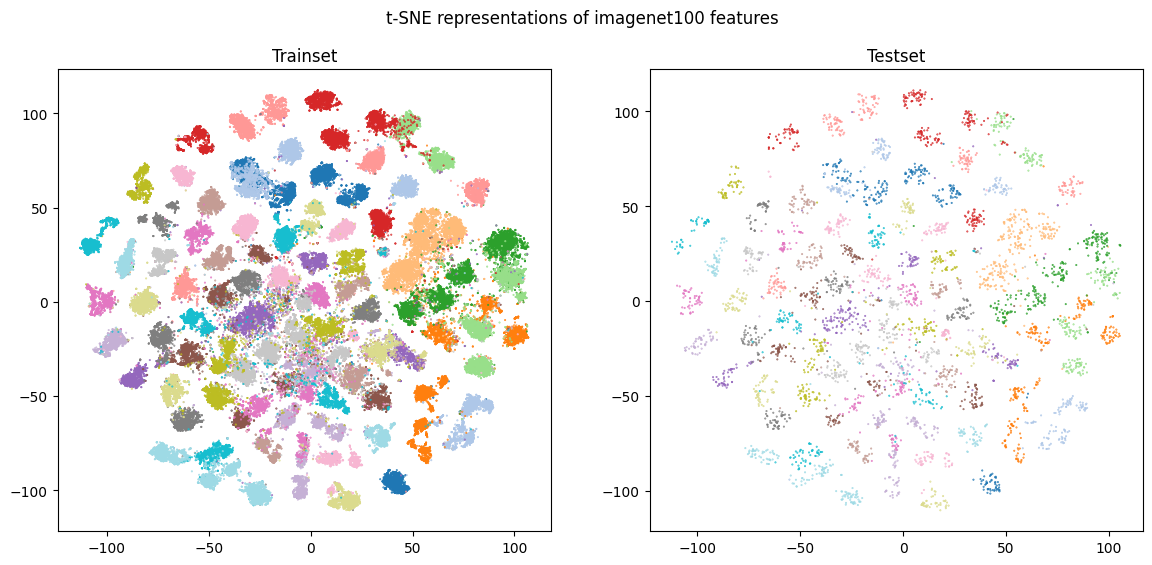

In [17]:
datasets = ["cifar10", "cifar100", "svhn", "imagenet100"]

for dataset in datasets:
    train_features, train_labels, test_features, test_labels, classes = get_dataset_and_classes(dataset)
    tnr, ttr = generate_pca(train_features, test_features)
    plot_feature_reps(train_reps=tnr, train_labels=train_labels, test_reps=ttr, test_labels=test_labels, classes=classes, title=f"PCA representations of {dataset} features")
    tnr, ttr = generate_tsne(train_features, test_features)
    plot_feature_reps(train_reps=tnr, train_labels=train_labels, test_reps=ttr, test_labels=test_labels, classes=classes, title=f"t-SNE representations of {dataset} features")


In [20]:
train_features, cifar100_train_labels, test_features, _, _ = get_dataset_and_classes("cifar100")
cifar100_tnr, _ = generate_tsne(train_features, test_features)

train_features, imagenet100_train_labels, test_features, _, _ = get_dataset_and_classes("imagenet100")
imagenet100_tnr, _ = generate_tsne(train_features, test_features)

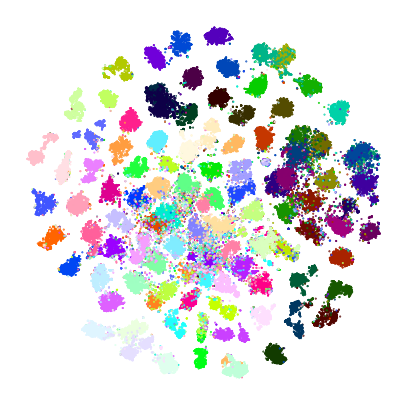

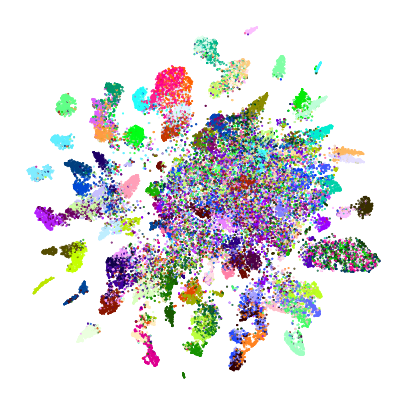

In [26]:
cmap = generate_colormap(100)

plt.figure(figsize=(5, 5))
plt.scatter(imagenet100_tnr[:, 0], imagenet100_tnr[:, 1], c=imagenet100_train_labels, s=0.2, cmap=cmap)
plt.axis('off')
plt.savefig("tsne_imagenet.pdf", bbox_inches="tight")
plt.show()

plt.figure(figsize=(5, 5))
plt.scatter(cifar100_tnr[:, 0], cifar100_tnr[:, 1], c=cifar100_train_labels, s=0.2, cmap=cmap)
plt.axis('off')
plt.savefig("tsne_cifar100.pdf", bbox_inches="tight")
plt.show()